In [1]:
# conda install -c conda-forge python-snappy snappy fastparquet
# conda install -c conda-forge umap-learn

In [2]:
#pip install pyarrow

In [3]:
#pip install umap-learn

In [4]:
#pip install umap-learn[plot]

In [5]:
#import pyarrow.parquet as pq
#from pyarrow import csv

In [6]:
import os
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

from sklearn.preprocessing import StandardScaler

import umap
import umap.plot

import warnings
warnings.filterwarnings('ignore')
#import fastparquet
#import pyarrow

In [11]:
data_path = os.path.join(os.getcwd(), 'data')
files = os.listdir(data_path)[1:]

In [12]:
#files

In [13]:
aisles = pd.read_csv(os.path.join(data_path,files[0]))
departments = pd.read_csv(os.path.join(data_path,files[1]))
orders = pd.read_csv(os.path.join(data_path,files[2]))
orders_products_prior = pd.read_csv(os.path.join(data_path,files[3]))
orders_products_train = pd.read_csv(os.path.join(data_path,files[4]))
products = pd.read_csv(os.path.join(data_path,files[5]))

In [14]:
#prior = orders[orders['eval_set']== 'prior']
#train = orders[orders['eval_set'] == 'train']
#test = orders[orders['eval_set'] == 'test']
#del train['eval_set'], test['eval_set'], prior['eval_set']

#temp = orders_products_train.set_index('order_id')
#orders_train = pd.merge(temp, train, on='order_id')

#temp = orders_products_prior.set_index('order_id')
#orders_prior = pd.merge(temp, prior, on='order_id')

#total_orders = pd.concat([orders_prior, orders_train])
#temp = pd.merge(total_orders,products , on='product_id')
#temp = pd.merge(temp, aisles, on='aisle_id')
#temp = pd.merge(temp, departments, on='department_id')

#temp.to_csv('total_order.csv', index=False)

In [15]:
#total_orders = pd.read_parquet('total_order.parquet', engine='fastparquet')

In [16]:
total_orders = pd.read_csv('total_order.csv')

* orders(340만 행, 206k 사용자):

order_id: 주문 식별자  
user_id: 고객 식별자  
eval_set: 이 주문이 속한 평가 세트( SET아래 설명 참조)  
order_number: 이 사용자의 주문 순서 번호(1 = 첫 번째, n = n 번째)  
order_dow: 주문한 요일  
order_hour_of_day: 주문이 접수된 시간  
days_since_prior: 마지막 주문 이후 일수, 최대 30일(NA order_number= 1)  
    
* products(50k 행):

product_id: 제품 식별자  
product_name: 제품명  
aisle_id: 외래 키  
department_id: 외래 키  

* aisles(134행):  

aisle_id: 상품 중분류 식별자  
aisle: 상품 중분류명 (ex. 에너지 그래놀라바, 인스턴트, 건면 등)

* deptartments(21행):

department_id: 상품 대분류 식별자  
department: 상품 대분류명 (ex. 냉동, 아기, 빵,과자, 동물, 주류 등)  

* order_products__SET(30m+ 행):

order_id: 외래 키  
product_id: 외래 키  
add_to_cart_order: 각 상품이 장바구니에 담긴 순서  
reordered: 이 제품이 과거에 이 사용자가 주문한 적이 있으면 1, 그렇지 않으면 0  
여기서 SET는 다음 네 가지 평가 세트 중 하나입니다( eval_set in orders).  

"prior": 해당 사용자의 가장 최근 주문 이전 주문(\~3.2m 주문)  
"train": 참가자에게 교육 데이터 제공(\~131k 주문)  
"test": 기계 학습 대회를 위해 예약된 테스트 데이터(~75k 주문)  

In [17]:
total_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,26,33120,5,0,153404,2,0,16,7.0,Organic Egg Whites,86,16,eggs,dairy eggs
2,120,33120,13,0,23750,11,6,8,10.0,Organic Egg Whites,86,16,eggs,dairy eggs
3,327,33120,5,1,58707,21,6,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
4,390,33120,28,1,166654,48,0,12,9.0,Organic Egg Whites,86,16,eggs,dairy eggs


## 주요 주문 시간대

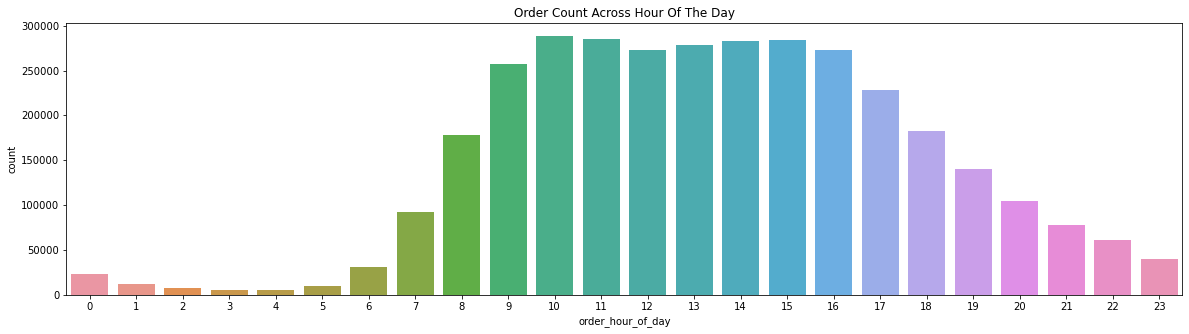

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.countplot(data=orders, x="order_hour_of_day", ax=ax)
ax.set( title="Order Count Across Hour Of The Day")
plt.show()

일반적인 근무시간대? 활동시간대에 주로 구매하고 계십니다

### 주문을 많이 하는 요일

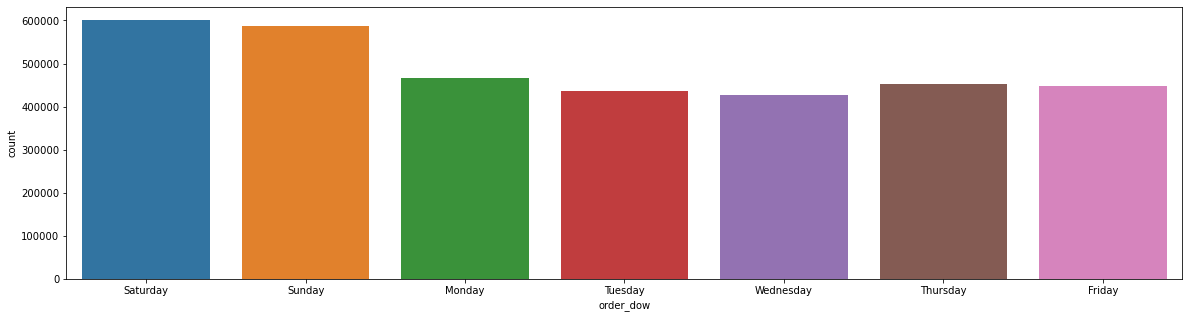

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
orders_day = orders[['order_dow']].replace({0:'Saturday', 1:'Sunday', 2:'Monday', 3:'Tuesday', 4:'Wednesday', 5:'Thursday', 6:'Friday'})
sns.countplot(data=orders_day, x='order_dow', ax=ax, order=['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
#ax.set(xlabel='Day of The Week', title='Order Count Across Days Of The Week')
plt.show()

(요일이 숫자로 되있었지만, 가장 구매가 많은 날을 토,일로 정했습니다.)  
토요일, 일요일이 구매량이 가장 많고, 평일에는 비슷한 경향을 보입니다

### 사람들은 언제 재주문 하는가

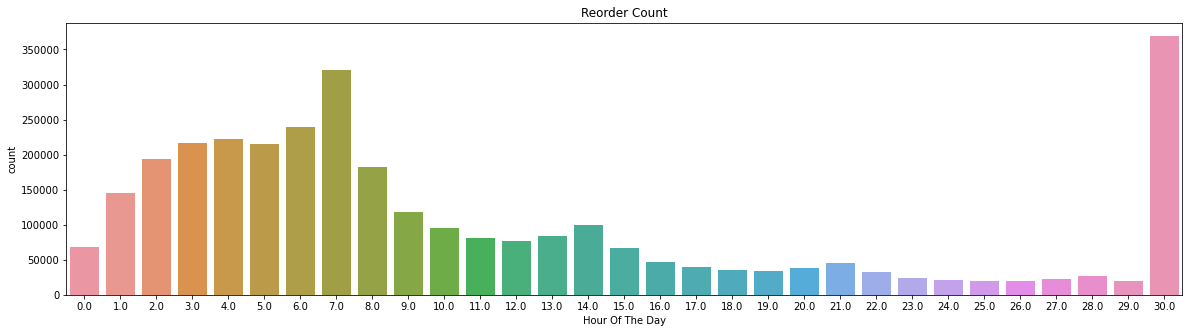

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
sns.countplot(data=orders, x='days_since_prior_order', ax=ax)
ax.set(xlabel='Hour Of The Day', title='Reorder Count')
plt.show()

구매후 30일, 7일째에 가장 많이 구매하고, 14, 21, 28일처럼 1주마다 소폭 상승하는 경향이 보입니다  
-> 30일 이후는 다 30일로 표기한다는 걸까요? 30일이 너무 많네요

### 사람들이 주문한 횟수

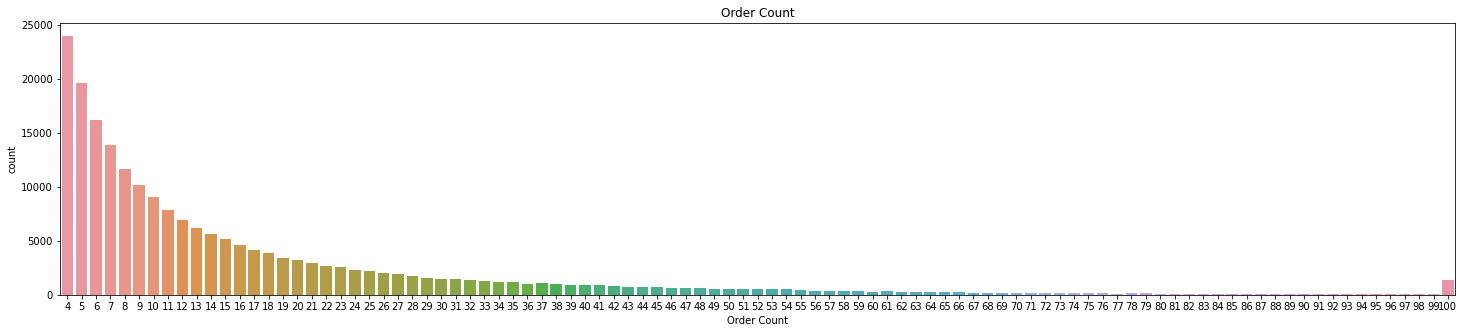

In [22]:
order_count = orders.groupby(by=['user_id'])['order_id'].count().to_frame()
fig, ax = plt.subplots()
fig.set_size_inches(25, 5)
sns.countplot(data=order_count, x='order_id', ax=ax)
ax.set(xlabel='Order Count', title='Order Count')
plt.show()

instacart를 4번 이용하신분들이 가장 많으시네요. 100번 주문하신분도 있으시네요.

### 한번 주문할때 얼마나 사는지

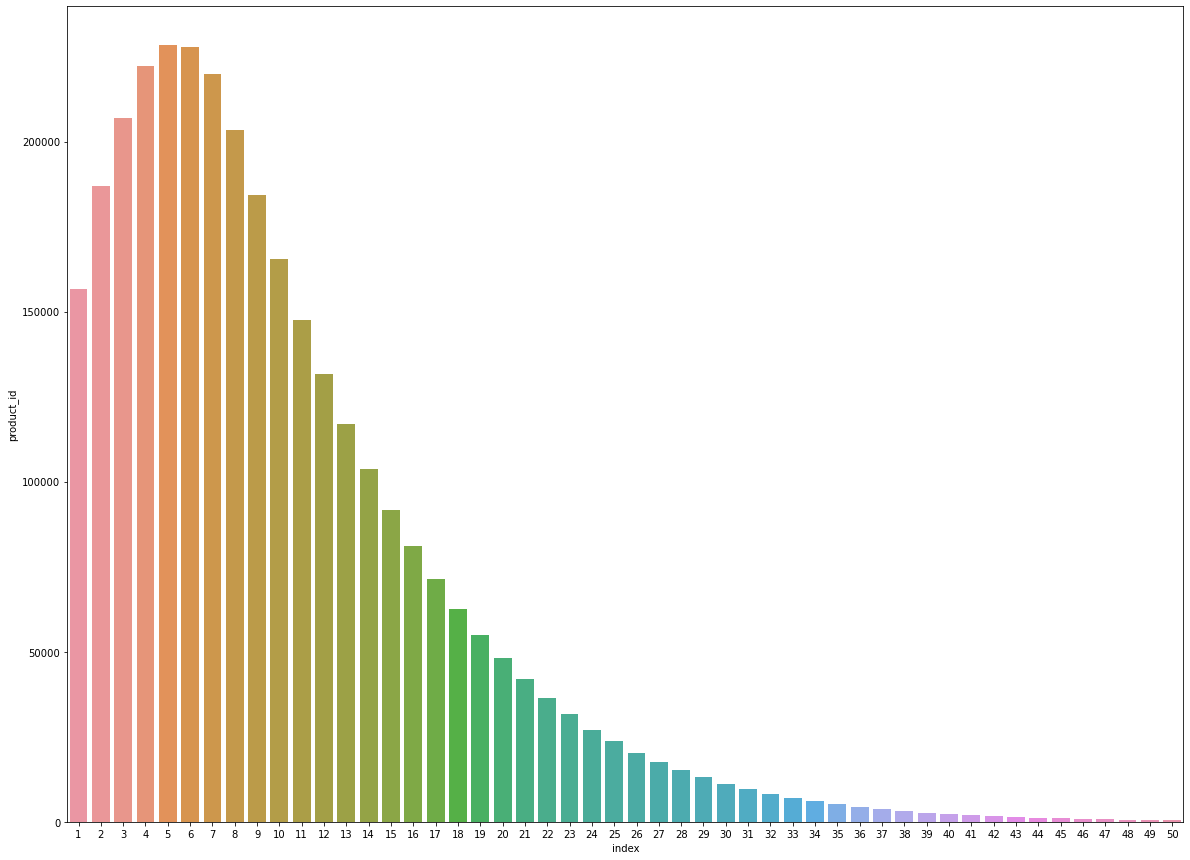

In [23]:
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 15)
order_product = orders_products_prior.groupby("order_id")["product_id"].count().to_frame()["product_id"].value_counts().to_frame().reset_index().head(50)
sns.barplot(data=order_product, x="index", y="product_id")
plt.show()

한번에 5~6종류를 가장 많이 구매하시네요

### 가장 많이 팔린 제품

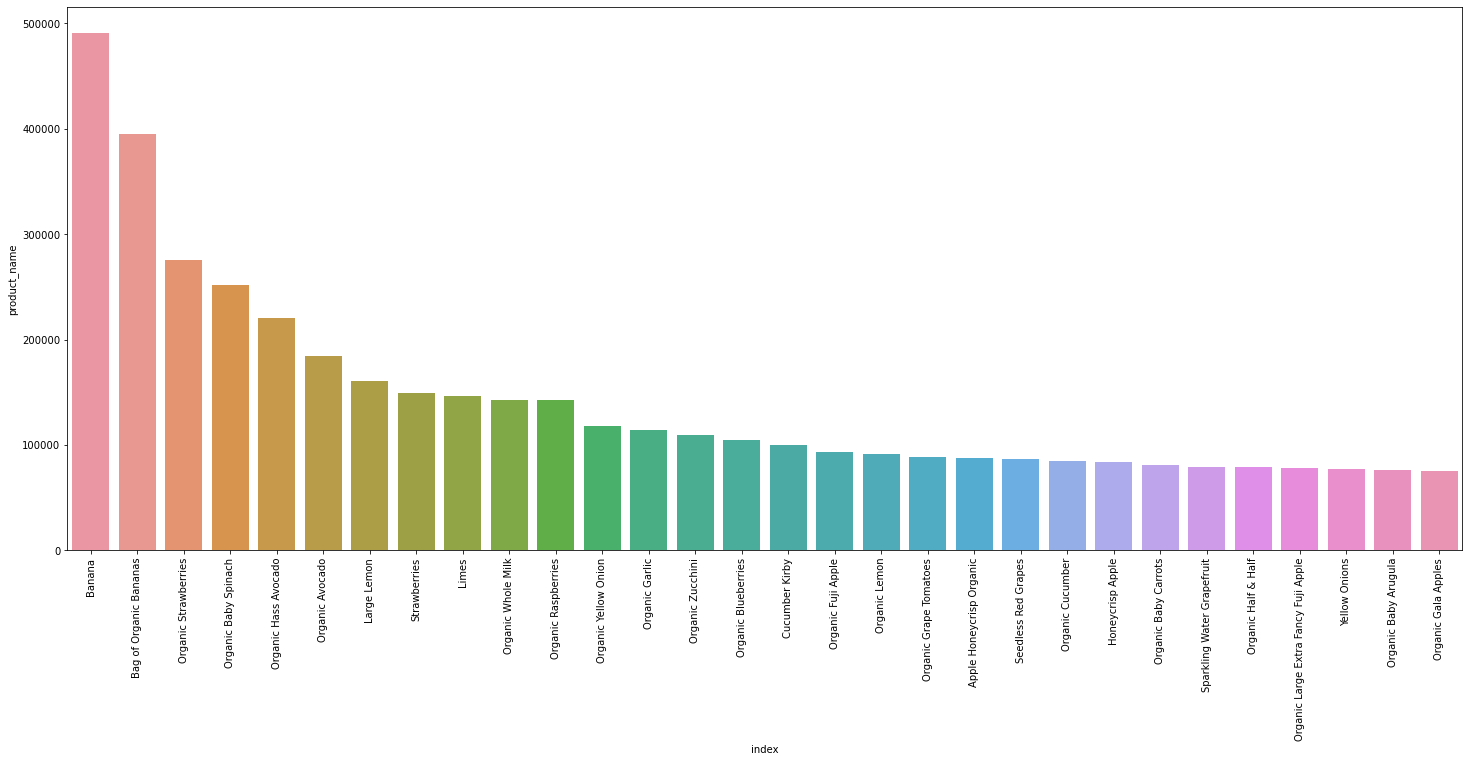

In [24]:
product_count = total_orders['product_name'].value_counts().to_frame().reset_index().head(30)
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
g = sns.barplot(data=product_count, x="index", y='product_name')
plt.xticks(rotation=90)
plt.show()

바나나, 딸기, 시금치, 아보카도가 잘팔리고, 양파, 루꼴라, 갈라 사과가 적게 팔리고 있네요.

### 가장 많이 팔린 aisle

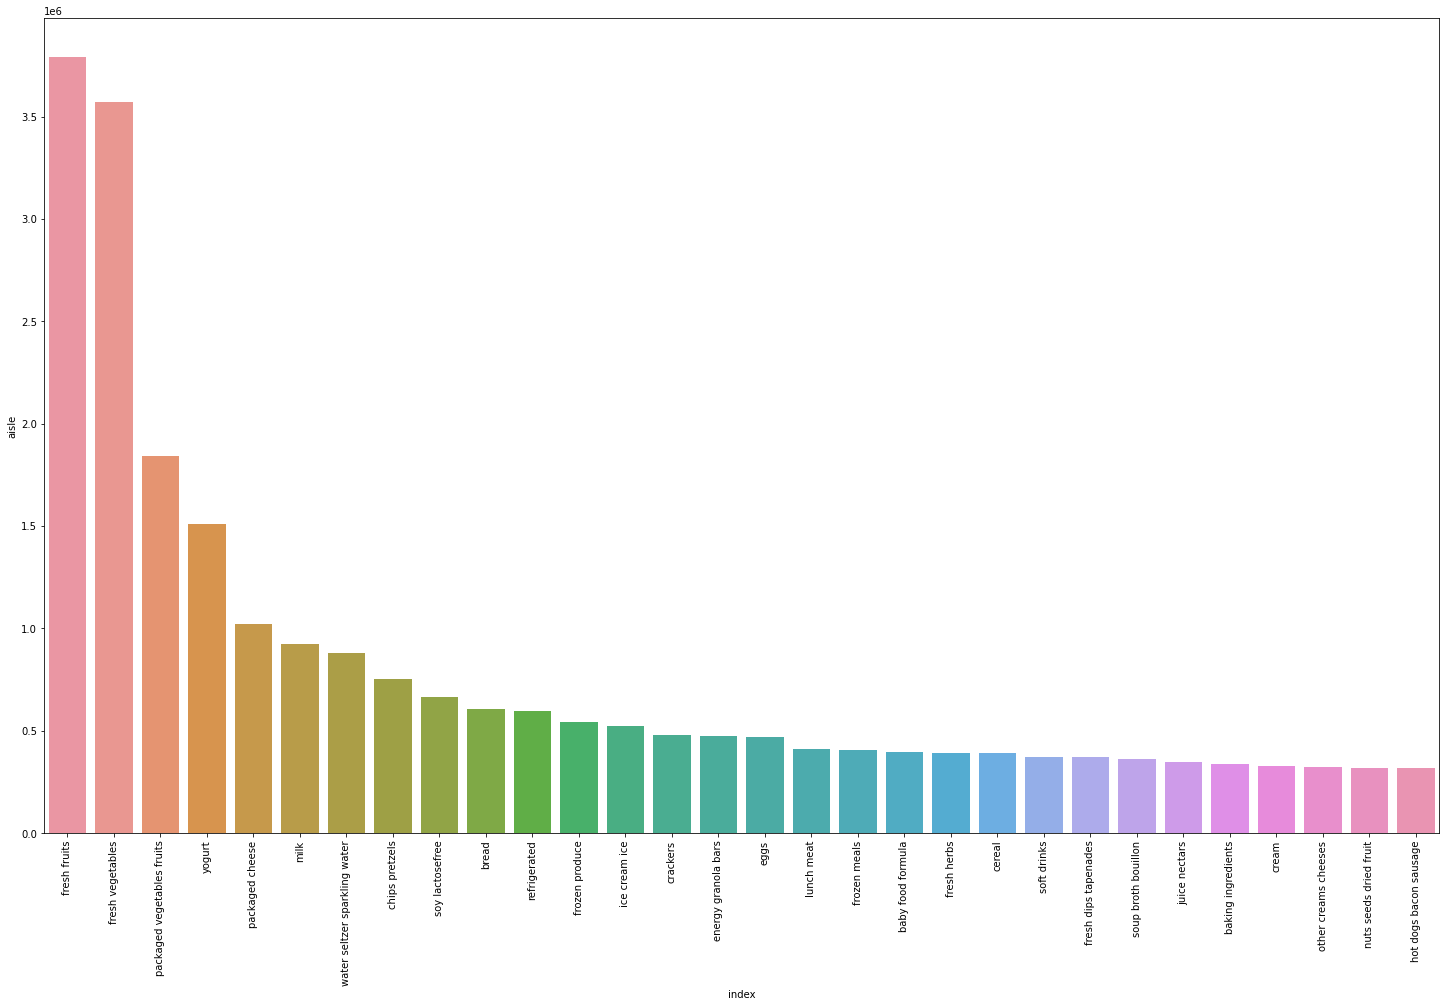

In [25]:
aisle_count = total_orders['aisle'].value_counts().to_frame().reset_index().head(30)

fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
sns.barplot(data=aisle_count, x='index', y='aisle', )
plt.xticks(rotation=90)
plt.show()

과일, 채소, 유제품류가 많이 팔리고, 크림, 건과일, 가공육류가 적게 팔리고있네요.

### 가장 많이 팔린 department

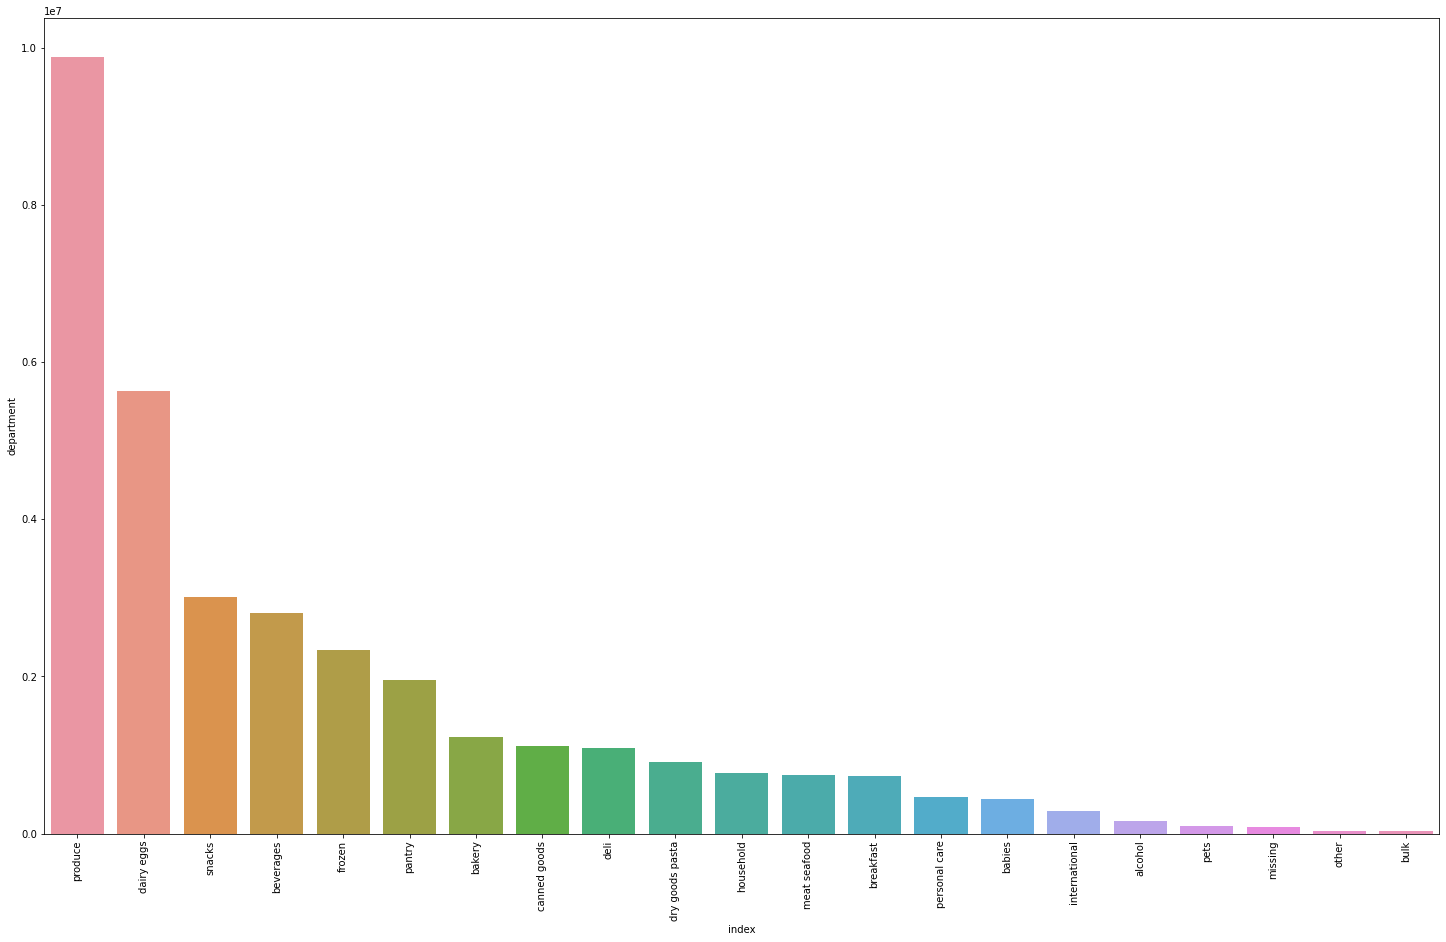

In [26]:
department_count = total_orders['department'].value_counts().to_frame().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
sns.barplot(data=department_count, x='index', y='department')
plt.xticks(rotation=90)
plt.show()

produce 채집품? 채소, 허브, 과일?

In [27]:
total_orders[total_orders['department'] == 'produce'].tail(20)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
15519425,916319,22010,8,0,56017,8,0,12,10.0,Italian Herbs Paste,16,4,fresh herbs,produce
15519426,1030250,22010,36,0,149704,5,2,12,13.0,Italian Herbs Paste,16,4,fresh herbs,produce
15519427,1269476,22010,19,0,7100,16,2,11,30.0,Italian Herbs Paste,16,4,fresh herbs,produce
15519428,1866457,22010,33,0,103732,13,3,9,8.0,Italian Herbs Paste,16,4,fresh herbs,produce
15519429,2443700,22010,25,0,17265,3,1,16,9.0,Italian Herbs Paste,16,4,fresh herbs,produce
15519430,2861768,22010,5,0,40540,4,3,14,6.0,Italian Herbs Paste,16,4,fresh herbs,produce
15519431,990818,7614,12,0,199065,6,0,14,18.0,Herbs Lime Leaves,16,4,fresh herbs,produce
15519432,1956949,7614,1,1,157818,9,3,14,30.0,Herbs Lime Leaves,16,4,fresh herbs,produce
15519433,1990232,7614,1,0,157818,3,2,13,1.0,Herbs Lime Leaves,16,4,fresh herbs,produce
15519434,3229638,7614,6,1,157818,4,6,21,4.0,Herbs Lime Leaves,16,4,fresh herbs,produce


### 요일별 가장 많이 팔린 상품

In [28]:
col_1, col_2 = [], []
for i in range(7):
    row = total_orders[total_orders['order_dow'] == i]['product_name'].value_counts().to_frame().iloc[0]
    col_1.append(row.name)
    col_2.append(row.product_name)
dow_product = pd.DataFrame([x for x in zip(col_1, col_2)])
dow_product.columns = ['product_name', 'count']
dow_product

,product_name,count
0,Banana,101474
1,Banana,90750
2,Banana,62002
3,Banana,55334
4,Banana,54447
5,Banana,61281
6,Banana,66003


In [29]:
col_1, col_2 = [], []
for i in range(7):
    row = total_orders[total_orders['order_dow'] == i]['product_name'].value_counts().to_frame()
    
    #col_1.append(row.name)
    #col_2.append(row.product_name)
#dow_product = pd.DataFrame([x for x in zip(col_1, col_2)])
#dow_product.columns = ['product_name', 'count']
#dow_product

In [30]:
dow_0 = total_orders[total_orders['order_dow'] == 0]['product_name'].value_counts().to_frame()
dow_0.columns = ['saturday']
dow_0.head(10)

,saturday
Banana,101474
Bag of Organic Bananas,75052
Organic Baby Spinach,57556
Organic Strawberries,56635
Organic Hass Avocado,45841
Organic Avocado,41877
Large Lemon,35826
Limes,31878
Strawberries,29046
Organic Raspberries,27756


In [31]:
dow_1 = total_orders[total_orders['order_dow'] == 1]['product_name'].value_counts().to_frame()
dow_1.columns = ['sunday']
dow_1.head(10)

,sunday
Banana,90750
Bag of Organic Bananas,72206
Organic Strawberries,47897
Organic Baby Spinach,43819
Organic Hass Avocado,39660
Organic Avocado,33450
Large Lemon,27996
Strawberries,26349
Organic Raspberries,25063
Organic Whole Milk,24025


In [32]:
dow_2 = total_orders[total_orders['order_dow'] == 2]['product_name'].value_counts().to_frame()
dow_2.columns = ['monday']
dow_2.head(10)

,monday
Banana,62002
Bag of Organic Bananas,52122
Organic Strawberries,33619
Organic Baby Spinach,31094
Organic Hass Avocado,28520
Organic Avocado,22365
Large Lemon,19513
Strawberries,19147
Organic Whole Milk,18229
Organic Raspberries,18120


In [33]:
dow_3 = total_orders[total_orders['order_dow'] == 3]['product_name'].value_counts().to_frame()
dow_3.columns = ['tuesday']
dow_3.head(10)

,tuesday
Banana,55334
Bag of Organic Bananas,47204
Organic Strawberries,31670
Organic Baby Spinach,26855
Organic Hass Avocado,25287
Organic Avocado,19629
Strawberries,17553
Organic Whole Milk,17088
Large Lemon,16967
Organic Raspberries,16885


In [34]:
dow_4 = total_orders[total_orders['order_dow'] == 4]['product_name'].value_counts().to_frame()
dow_4.columns = ['wednesday']
dow_4.head(10)

,wednesday
Banana,54447
Bag of Organic Bananas,46358
Organic Strawberries,31886
Organic Baby Spinach,26290
Organic Hass Avocado,24897
Organic Avocado,19186
Strawberries,17771
Organic Whole Milk,17186
Large Lemon,16924
Organic Raspberries,16628


In [35]:
dow_5 = total_orders[total_orders['order_dow'] == 5]['product_name'].value_counts().to_frame()
dow_5.columns = ['thursday']
dow_5.head(10)

,thursday
Banana,61281
Bag of Organic Bananas,50545
Organic Strawberries,35534
Organic Baby Spinach,29489
Organic Hass Avocado,27082
Organic Avocado,21543
Large Lemon,19877
Strawberries,19555
Limes,18886
Organic Raspberries,18815


In [36]:
dow_6 = total_orders[total_orders['order_dow'] == 6]['product_name'].value_counts().to_frame()
dow_6.columns = ['friday']
dow_6.head(10)

,friday
Banana,66003
Bag of Organic Bananas,51443
Organic Strawberries,38336
Organic Baby Spinach,36602
Organic Hass Avocado,29590
Organic Avocado,26174
Large Lemon,23689
Limes,23368
Organic Whole Milk,20198
Strawberries,20024


요일별 가장 많이 팔린 상품은 바나나입니다.

### 시간대별 가장 많이 팔린 상품 

In [41]:
dow_7 = dow_0.reset_index()

In [42]:
dow_7 = dow_7.merge(dow_1.reset_index(), how='inner', on='index')
dow_7 = dow_7.merge(dow_2.reset_index(), how='inner', on='index')
dow_7 = dow_7.merge(dow_3.reset_index(), how='inner', on='index')
dow_7 = dow_7.merge(dow_4.reset_index(), how='inner', on='index')
dow_7 = dow_7.merge(dow_5.reset_index(), how='inner', on='index')
dow_7 = dow_7.merge(dow_6.reset_index(), how='inner', on='index')

In [49]:
dow_7

,index,saturday,sunday,monday,tuesday,wednesday,thursday,friday
0,Banana,101474,90750,62002,55334,54447,61281,66003
1,Bag of Organic Bananas,75052,72206,52122,47204,46358,50545,51443
2,Organic Baby Spinach,57556,43819,31094,26855,26290,29489,36602
3,Organic Strawberries,56635,47897,33619,31670,31886,35534,38336
4,Organic Hass Avocado,45841,39660,28520,25287,24897,27082,29590
...,...,...,...,...,...,...,...,...
37340,Sliced Italian Bread,1,1,2,1,4,2,2
37341,Omega Flax,1,5,3,1,2,1,3
37342,Home Bake California Sourdough Baguettes,1,1,2,1,2,3,1
37343,Cheesy Skillets Dinner Kit,1,6,1,1,2,3,1


In [55]:
dow_10 = dow_7.head(10)
dow_10 = dow_10.set_index('index').T
dow_10

index,Banana,Bag of Organic Bananas,Organic Baby Spinach,Organic Strawberries,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Raspberries
saturday,101474,75052,57556,56635,45841,41877,35826,31878,29046,27756
sunday,90750,72206,43819,47897,39660,33450,27996,23949,26349,25063
monday,62002,52122,31094,33619,28520,22365,19513,17184,19147,18120
tuesday,55334,47204,26855,31670,25287,19629,16967,15521,17553,16885
wednesday,54447,46358,26290,31886,24897,19186,16924,15874,17771,16628
thursday,61281,50545,29489,35534,27082,21543,19877,18886,19555,18815
friday,66003,51443,36602,38336,29590,26174,23689,23368,20024,19336


In [56]:
dow_11 = dow_10['Banana'].to_frame().reset_index()
dow_11['product_name'] = 'Banana'
dow_11.rename(columns={'Banana':'count'},inplace=True)
dow_11

,index,count,product_name
0,saturday,101474,Banana
1,sunday,90750,Banana
2,monday,62002,Banana
3,tuesday,55334,Banana
4,wednesday,54447,Banana
5,thursday,61281,Banana
6,friday,66003,Banana


In [57]:
dow_12 = dow_10['Bag of Organic Bananas'].to_frame().reset_index()
dow_12['product_name'] = 'Bag of Organic Bananas'
dow_12.rename(columns={'Bag of Organic Bananas':'count'},inplace=True)
dow_12

,index,count,product_name
0,saturday,75052,Bag of Organic Bananas
1,sunday,72206,Bag of Organic Bananas
2,monday,52122,Bag of Organic Bananas
3,tuesday,47204,Bag of Organic Bananas
4,wednesday,46358,Bag of Organic Bananas
5,thursday,50545,Bag of Organic Bananas
6,friday,51443,Bag of Organic Bananas


In [58]:
dow_13 = dow_10['Organic Baby Spinach'].to_frame().reset_index()
dow_13['product_name'] = 'Organic Baby Spinach'
dow_13.rename(columns={'Organic Baby Spinach':'count'},inplace=True)
dow_13

,index,count,product_name
0,saturday,57556,Organic Baby Spinach
1,sunday,43819,Organic Baby Spinach
2,monday,31094,Organic Baby Spinach
3,tuesday,26855,Organic Baby Spinach
4,wednesday,26290,Organic Baby Spinach
5,thursday,29489,Organic Baby Spinach
6,friday,36602,Organic Baby Spinach


In [59]:
dow_14 = dow_10['Organic Strawberries'].to_frame().reset_index()
dow_14['product_name'] = 'Organic Strawberries'
dow_14.rename(columns={'Organic Strawberries':'count'},inplace=True)
dow_14

,index,count,product_name
0,saturday,56635,Organic Strawberries
1,sunday,47897,Organic Strawberries
2,monday,33619,Organic Strawberries
3,tuesday,31670,Organic Strawberries
4,wednesday,31886,Organic Strawberries
5,thursday,35534,Organic Strawberries
6,friday,38336,Organic Strawberries


In [60]:
dow_15 = dow_10['Organic Hass Avocado'].to_frame().reset_index()
dow_15['product_name'] = 'Organic Hass Avocado'
dow_15.rename(columns={'Organic Hass Avocado':'count'},inplace=True)
dow_15

,index,count,product_name
0,saturday,45841,Organic Hass Avocado
1,sunday,39660,Organic Hass Avocado
2,monday,28520,Organic Hass Avocado
3,tuesday,25287,Organic Hass Avocado
4,wednesday,24897,Organic Hass Avocado
5,thursday,27082,Organic Hass Avocado
6,friday,29590,Organic Hass Avocado


In [61]:
dow_16 = dow_10['Organic Avocado'].to_frame().reset_index()
dow_16['product_name'] = 'Organic Avocado'
dow_16.rename(columns={'Organic Avocado':'count'},inplace=True)
dow_16

,index,count,product_name
0,saturday,41877,Organic Avocado
1,sunday,33450,Organic Avocado
2,monday,22365,Organic Avocado
3,tuesday,19629,Organic Avocado
4,wednesday,19186,Organic Avocado
5,thursday,21543,Organic Avocado
6,friday,26174,Organic Avocado


In [62]:
dow_17 = dow_10['Large Lemon'].to_frame().reset_index()
dow_17['product_name'] = 'Large Lemon'
dow_17.rename(columns={'Large Lemon':'count'},inplace=True)
dow_17

,index,count,product_name
0,saturday,35826,Large Lemon
1,sunday,27996,Large Lemon
2,monday,19513,Large Lemon
3,tuesday,16967,Large Lemon
4,wednesday,16924,Large Lemon
5,thursday,19877,Large Lemon
6,friday,23689,Large Lemon


In [63]:
dow_18 = dow_10['Limes'].to_frame().reset_index()
dow_18['product_name'] = 'Limes'
dow_18.rename(columns={'Limes':'count'},inplace=True)
dow_18

,index,count,product_name
0,saturday,31878,Limes
1,sunday,23949,Limes
2,monday,17184,Limes
3,tuesday,15521,Limes
4,wednesday,15874,Limes
5,thursday,18886,Limes
6,friday,23368,Limes


In [64]:
dow_21 = pd.concat([dow_11, dow_12], ignore_index=True)
dow_21 = pd.concat([dow_21, dow_13], ignore_index=True)
dow_21 = pd.concat([dow_21, dow_14], ignore_index=True)
dow_21 = pd.concat([dow_21, dow_15], ignore_index=True)
dow_21 = pd.concat([dow_21, dow_16], ignore_index=True)
dow_21 = pd.concat([dow_21, dow_17], ignore_index=True)
dow_21 = pd.concat([dow_21, dow_18], ignore_index=True)
dow_21

,index,count,product_name
0,saturday,101474,Banana
1,sunday,90750,Banana
2,monday,62002,Banana
3,tuesday,55334,Banana
4,wednesday,54447,Banana
5,thursday,61281,Banana
6,friday,66003,Banana
7,saturday,75052,Bag of Organic Bananas
8,sunday,72206,Bag of Organic Bananas
9,monday,52122,Bag of Organic Bananas


In [65]:
dow_total = dow_21.replace({'saturday':0, 'sunday':1, 'monday':2, 'tuesday':3, 'wednesday':4, 'thursday':5, 'friday':6})
dow_total.rename(columns=({'index':'order_dow'}), inplace=True)
dow_total.reset_index()
dow_total

,order_dow,count,product_name
0,0,101474,Banana
1,1,90750,Banana
2,2,62002,Banana
3,3,55334,Banana
4,4,54447,Banana
5,5,61281,Banana
6,6,66003,Banana
7,0,75052,Bag of Organic Bananas
8,1,72206,Bag of Organic Bananas
9,2,52122,Bag of Organic Bananas


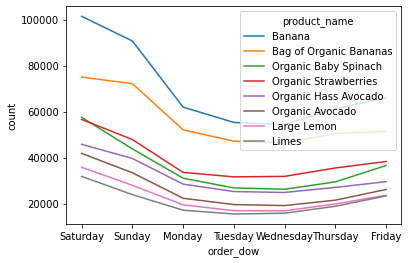

In [66]:
ax = sns.lineplot(x='order_dow', y='count', hue='product_name', data=dow_total)
plt.xticks([0, 1, 2, 3, 4, 5, 6],['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday'])
plt.show()

In [72]:
dow_31 = dow_7.copy().head(10)
dow_31.rename(columns={'index': 'product_name'}, inplace=True)
dow_31 = dow_31.set_index('product_name').T
dow_31.reset_index()

product_name,index,Banana,Bag of Organic Bananas,Organic Baby Spinach,Organic Strawberries,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Raspberries
0,saturday,101474,75052,57556,56635,45841,41877,35826,31878,29046,27756
1,sunday,90750,72206,43819,47897,39660,33450,27996,23949,26349,25063
2,monday,62002,52122,31094,33619,28520,22365,19513,17184,19147,18120
3,tuesday,55334,47204,26855,31670,25287,19629,16967,15521,17553,16885
4,wednesday,54447,46358,26290,31886,24897,19186,16924,15874,17771,16628
5,thursday,61281,50545,29489,35534,27082,21543,19877,18886,19555,18815
6,friday,66003,51443,36602,38336,29590,26174,23689,23368,20024,19336


In [74]:
dow_32 = dow_31['Banana'].to_frame().reset_index().merge(dow_31['Bag of Organic Bananas'].to_frame().reset_index(), how='inner', on='index')
dow_32

,index,Banana,Bag of Organic Bananas
0,saturday,101474,75052
1,sunday,90750,72206
2,monday,62002,52122
3,tuesday,55334,47204
4,wednesday,54447,46358
5,thursday,61281,50545
6,friday,66003,51443


<AxesSubplot:>

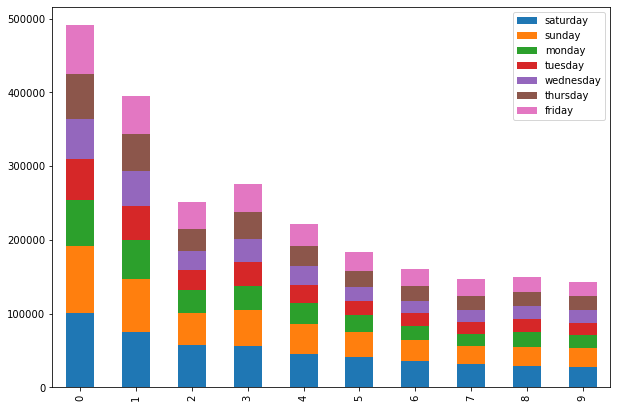

In [75]:
dow_10.plot.bar(stacked=True, figsize=(10,7))

In [80]:
col_3, col_4 = [], []
for i in range(24):
    row = total_orders[total_orders['order_hour_of_day'] == i]['product_name'].value_counts().to_frame().iloc[0]
    col_3.append(row.name)
    col_4.append(row.product_name)
hour_product = pd.DataFrame([x for x in zip(col_3, col_4)])
hour_product.columns = ['product_name', 'count']
hour_product

,product_name,count
0,Banana,2915
1,Banana,1467
2,Banana,867
3,Banana,612
4,Banana,713
5,Banana,1368
6,Banana,4943
7,Banana,15060
8,Banana,28445
9,Banana,39352


시간대별 가장 많이 팔린 상품은 바나나입니다. 신기하네요  

밑은 혹시 몰라서 가장 많이 팔린 시간대와 가장 적게 팔린 시간대에 판매상품 순위에요

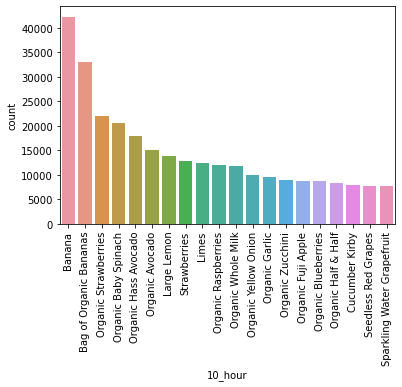

In [81]:
hour_10 = total_orders[total_orders['order_hour_of_day'] == 10]['product_name'].value_counts().to_frame().head(20)
hour_10.columns = ['hour_10']
hour_10.reset_index(inplace=True)
hour_10.rename(columns=({'index':'10_hour', 'hour_10':'count'}), inplace=True)

sns.barplot(data=hour_10, x="10_hour", y="count")
plt.xticks(rotation=90)
plt.show()

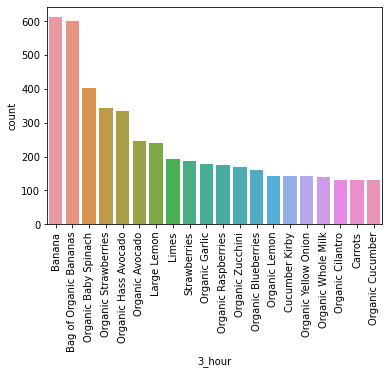

In [82]:
hour_3 = total_orders[total_orders['order_hour_of_day'] == 3]['product_name'].value_counts().to_frame().head(20)
hour_3.columns = ['hour_3']
hour_3.reset_index(inplace=True)
hour_3.rename(columns=({'index':'3_hour', 'hour_3':'count'}), inplace=True)

sns.barplot(data=hour_3, x="3_hour", y="count")
plt.xticks(rotation=90)
plt.show()

가장 많이 팔린 시간대인 10시에 오시는 분들보다 새벽 3시에 오시는 분들은 바나나 낱개보다는 바나나 가방?의 구매비율이 높네요

### 개인 구매품목 관련

In [84]:
total_orders[total_orders['user_id'] == 1][total_orders['order_id'] == 2550362]['product_name'].to_frame()

,product_name
619383,0% Greek Strained Yogurt
2108933,Organic Unsweetened Almond Milk
4187825,Organic String Cheese
22021354,Milk Chocolate Almonds
22296218,Original Beef Jerky
22477423,Pistachios
23236259,Cinnamon Toast Crunch
25615318,Soda
25793705,Zero Calorie Cola


In [87]:
total_orders[total_orders['user_id'] == 1][total_orders['order_id'] == 1187899]['product_name'].to_frame()

,product_name
622922,0% Greek Strained Yogurt
2824115,Organic Whole Milk
4189479,Organic String Cheese
4666511,Organic Half & Half
22022753,Milk Chocolate Almonds
22275372,Aged White Cheddar Popcorn
22477964,Pistachios
23237245,Cinnamon Toast Crunch
25625070,Soda
25796052,Zero Calorie Cola


0% Greek Strained Yogurt, Organic String Cheese, Milk Chocolate Almonds 등 처럼 개인마다 주문마다 공통적으로 구매하는 물품이 존재